In [158]:

import urllib.request
import time

In [78]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt

In [79]:
df = pd.read_csv('./ChatbotData.csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [80]:
df['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [81]:
df.rename(columns={'Q':'text'},inplace=True)
df.head()

,text,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [82]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [83]:
df['label']=le.fit_transform(df['label'])
df['label'].value_counts(normalize=True)

0    0.447433
1    0.301954
2    0.250613
Name: label, dtype: float64

In [84]:
train_text, train_labels=df['text'], df['label']

In [85]:
from transformers import AutoModel, BertTokenizerFast

In [86]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
from transformers import RobertaTokenizer, RobertaModel

In [88]:
# Load the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Import Roberta pretrained model
bert = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [89]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [90]:
text = ["this is a distil bert model.","data is oil"]

In [91]:
encoded_input=tokenizer(text, padding=True, truncation=True, return_tensors='pt') #tokenization, truncate sentence 
print(encoded_input)

#1 - Actual token
#0 - Padded token

{'input_ids': tensor([[  101,  2023,  2003,  1037,  4487, 16643,  2140, 14324,  2944,  1012,
           102],
        [  101,  2951,  2003,  3514,   102,     0,     0,     0,     0,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


<AxesSubplot:>

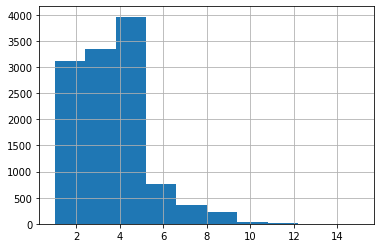

In [92]:
seq_len=[len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins=10)

In [93]:
max_seq_len=8
tokens_train=tokenizer(train_text.tolist(), max_length=max_seq_len, pad_to_max_length=True, truncation=True, return_token_type_ids=False) 
#[[101, 1045], [2986, 1012]]
#"[CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]" but false

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [94]:
train_seq=torch.tensor(tokens_train['input_ids'])
train_mask=torch.tensor(tokens_train['attention_mask'])
train_y=torch.tensor(train_labels.tolist())

In [95]:
# tokens_train.keys()

In [96]:
train_mask

tensor([[1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [97]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [98]:
batch_size = 10

# wrap tensors
train_data=TensorDataset(train_seq, train_mask, train_y) 

# sampler for sampling the data during training
train_sampler=RandomSampler(train_data) 
#given probabilities (weights)
#([0.9, 0.4, 0.05, 0.2, 0.3, 0.1], 5, replacement=False))
#[0, 1, 4, 3, 2]

train_dataloader=DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [99]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert=bert
        
        self.dropout=nn.Dropout(0.2)
        
        self.relu=nn.ReLU()
        
        self.fc1=nn.Linear(768,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256, 3)
        
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self, sent_id, mask):
        cls_hs=self.bert(sent_id, attention_mask=mask)[0][:,0]
        
        x=self.fc1(cls_hs)
        x=self.relu(x)
        x=self.dropout(x)
        
        x=self.fc2(x)
        x=self.relu(x)
        x=self.dropout(x)
        
        x=self.fc3(x)
        
        x=self.softmax(x)
        
        return x

In [100]:
for param in bert.parameters():
    param.requires_grad=False
    
model=BERT_Arch(bert)

In [101]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           771
├─LogSoftmax: 1-7                                       --
Total pa

In [102]:
from transformers import AdamW

In [103]:
optimizer=AdamW(model.parameters(), lr=1e-3)

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [104]:
from sklearn.utils.class_weight import compute_class_weight

In [105]:
class_wts=compute_class_weight('balanced',np.unique(train_labels), train_labels)


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=0        0
1        0
2        0
3        0
4        0
        ..
11818    2
11819    2
11820    2
11821    2
11822    2
Name: label, Length: 11823, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [106]:
len(class_wts)

3

In [107]:
class_wts

array([0.74499055, 1.10392157, 1.33007087])

In [108]:
weights=torch.tensor(class_wts, dtype=torch.float)
weights

tensor([0.7450, 1.1039, 1.3301])

In [109]:
cross_entropy=nn.NLLLoss(weight=weights)
cross_entropy

NLLLoss()

In [110]:
import torch.optim as optim

In [120]:
train_losses=[]
epochs=2
lr_sch=optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [121]:
def train():
    model.train()
    total_loss=0
    
    total_preds=[]
    
    for step, batch in enumerate(train_dataloader):
        if step%100==0 and not step==0:
            print('batch {:>5,} of {:>5,}.'.format(step,len(train_dataloader)))
        
        batch=[r for r in batch]
        sent_id, mask, labels=batch 
        
        preds=model(sent_id, mask)

        
        loss=cross_entropy(preds, labels) #labels=y
        
        total_loss=total_loss+loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        optimizer.step()
        optimizer.zero_grad()
#         lr_sch.step()

        preds=preds.detach().numpy()
        total_preds.append(preds)
        
    avg_loss=total_loss/len(train_dataloader)

    total_preds=np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

In [122]:
len(train_dataloader)

1183

In [118]:
train_dataloader

In [123]:
for epoch in range(epochs):
    print('\n Epoch {}/{}'.format(epoch+1, epochs))
    
    train_loss, _=train()
    train_losses.append(train_loss)
    
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
print(f'\n training loss:{train_loss:.3f}')


 Epoch 1/2
batch   100 of 1,183.
batch   200 of 1,183.
batch   300 of 1,183.
batch   400 of 1,183.
batch   500 of 1,183.
batch   600 of 1,183.
batch   700 of 1,183.
batch   800 of 1,183.
batch   900 of 1,183.
batch 1,000 of 1,183.
batch 1,100 of 1,183.

 Epoch 2/2
batch   100 of 1,183.
batch   200 of 1,183.
batch   300 of 1,183.
batch   400 of 1,183.
batch   500 of 1,183.
batch   600 of 1,183.
batch   700 of 1,183.
batch   800 of 1,183.
batch   900 of 1,183.
batch 1,000 of 1,183.
batch 1,100 of 1,183.

 training loss:0.989


In [124]:
data = {"intents": [
{"tag": 0,
 "responses": ["하루가 또 가네요.", "위로해 드립니다.", "여행은 언제나 좋죠.",   "눈살이 찌푸려지죠.", "응원합니다!"]},
{"tag": 1,
 "responses": ["더 오래 만날 사람 만날 거예요.", "더 공허함이 크시겠네요.", "더 좋은 사람 만나실 거예요.", "더 마음이 허하겠어요."]},
{"tag": 2,
 "responses": ["짝사랑 만큼 감정소모가 큰 건 없을 거예요.", "정열적인 사랑을 하고 있나봐요.",  "서로 깊게 알게되면서 더 좋아졌나봅니다."]}
]}


In [37]:
import re

In [191]:
def get_prediction(str):
    str=re.sub(r'[^a-zA-Z ]+', '', str)
    test_text=[str]
    model.eval()
    
    tokens_test_data=tokenizer(test_text, max_length=max_seq_len, pad_to_max_length=True, truncation=True, return_token_type_ids=False)
    
#     return tokens_test_data

    test_seq=torch.tensor(tokens_test_data['input_ids'])
    test_mask=torch.tensor(tokens_test_data['attention_mask'])
    

    preds=None
    
    with torch.no_grad():
        preds=model(test_seq, test_mask)
#         preds=preds.squeeze()
    preds=preds.detach().numpy()
#     print(preds.shape)
    preds=np.argmax(preds, axis=1)
    print('intent identified: ', le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]

In [187]:
get_prediction('하루가 또 가네요.')

intent identified:  1


1

In [200]:
def get_response(message): 
    intent = get_prediction(message)
#     result=None
    for i in data['intents']: 
        if i["tag"] == intent:
            result = random.choice(i["responses"])
            break
    print(f"Response : {result}")
    return intent, result

In [204]:
get_response('힘들어서 결혼할까봐')

intent identified:  1
Response : 더 공허함이 크시겠네요.


(1, '더 공허함이 크시겠네요.')

In [129]:
df

,text,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [134]:
data

{'intents': [{'tag': 0,
   'responses': ['하루가 또 가네요.',
    '위로해 드립니다.',
    '여행은 언제나 좋죠.',
    '눈살이 찌푸려지죠.',
    '응원합니다!']},
  {'tag': 1,
   'responses': ['더 오래 만날 사람 만날 거예요.',
    '더 공허함이 크시겠네요.',
    '더 좋은 사람 만나실 거예요.',
    '더 마음이 허하겠어요.']},
  {'tag': 2,
   'responses': ['짝사랑 만큼 감정소모가 큰 건 없을 거예요.',
    '정열적인 사랑을 하고 있나봐요.',
    '서로 깊게 알게되면서 더 좋아졌나봅니다.']}]}